# Predicting Game Outcome Using Team & Player Stats

NBA Seasons 2019-2022

In [4]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## 1. Data Cleaning & Processing

In [32]:
# read data source
df_full = pd.read_csv('nba_stats.csv',index_col=False,usecols=['Team_Score','Opponent_Score','game_date','game_id','Team_Abbrev','Opponent_Abbrev','stl','blk','drb','fg','fg3','ft','orb','ast','pts'])

In [33]:
df_full.shape

(115715, 15)

In [34]:
df_full.drop_duplicates(inplace=True)

In [35]:
df_full.shape

(78824, 15)

In [36]:
df_full.reset_index(inplace=True,drop=True)

In [37]:
# calculate win/lose field
winlose = []
for i in range(0,df_full.shape[0]):
    if ((df_full['Team_Score'][i]) < (df_full['Opponent_Score'][i])):
        winlose.append(0)
    else:
        winlose.append(1)

df_full['outcome'] = winlose

In [38]:
#convert game date to datetime field
df_full['game_date'] = pd.to_datetime(df_full['game_date'])

In [39]:
#get list of columns that contain NaN values
columns_with_nan = df_full.columns[df_full.isna().any()].tolist()

print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [40]:
#drop rows with nan values
df_full_cleaned = df_full.copy()

In [41]:
df_full_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78824 entries, 0 to 78823
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   game_id          78824 non-null  object        
 1   game_date        78824 non-null  datetime64[ns]
 2   Team_Abbrev      78824 non-null  object        
 3   Team_Score       78824 non-null  int64         
 4   Opponent_Abbrev  78824 non-null  object        
 5   Opponent_Score   78824 non-null  int64         
 6   fg               78824 non-null  int64         
 7   fg3              78824 non-null  int64         
 8   ft               78824 non-null  int64         
 9   orb              78824 non-null  int64         
 10  drb              78824 non-null  int64         
 11  ast              78824 non-null  int64         
 12  stl              78824 non-null  int64         
 13  blk              78824 non-null  int64         
 14  pts              78824 non-null  int64

In [42]:
df_full_cleaned.shape

(78824, 16)

In [43]:
#Define the pure defensive and offensive player stats (By pure I mean those stats that can only be regarded as defensive or offensive)--excluding percentages as a fg percentage of 100% is misleading if the player only attempted one fg.
player_def_stats_cols = ['game_id','Team_Abbrev','Opponent_Abbrev','outcome','stl','blk','drb']

player_off_stats_cols = ['game_id','Team_Abbrev','Opponent_Abbrev','outcome','fg','fg3','ft','orb','ast','pts']

In [44]:
#create player def stats dataframe
df_player_def = df_full_cleaned[player_def_stats_cols]

#create player off stats dataframe
df_player_off = df_full_cleaned[player_off_stats_cols]

#create df with combined (def+off) player stats
df_player_combined = df_full_cleaned[player_def_stats_cols + player_off_stats_cols]
df_player_combined = df_player_combined.iloc[:,4:]

In [45]:
df_player_def.shape, df_player_off.shape, df_player_combined.shape

((78824, 7), (78824, 10), (78824, 13))

In [46]:
#aggregate stats by team
df_def_agg = df_player_def.groupby(by=['game_id','Team_Abbrev','Opponent_Abbrev','outcome'],as_index=False).agg (sumdrb = ('drb','sum'),sumstl=('stl','sum'),sumblk=('blk','sum'))
df_off_agg = df_player_off.groupby(by=['game_id','Team_Abbrev','Opponent_Abbrev','outcome'],as_index=False).agg (sumfg = ('fg','sum'),sumfg3=('fg3','sum'),sumft=('ft','sum'),sumorb=('orb','sum'),sumast=('ast','sum'),sumpts=('pts','sum'))
df_combined_agg = df_player_combined.groupby(by=['game_id','Team_Abbrev','Opponent_Abbrev','outcome'],as_index=False).agg (sumfg = ('fg','sum'),sumfg3=('fg3','sum'),sumft=('ft','sum'),sumorb=('orb','sum'),sumast=('ast','sum'),sumpts=('pts','sum'),sumdrb = ('drb','sum'),sumstl=('stl','sum'),sumblk=('blk','sum'))

In [47]:
df_combined_agg.columns, df_def_agg.columns, df_off_agg.columns

(Index(['game_id', 'Team_Abbrev', 'Opponent_Abbrev', 'outcome', 'sumfg',
        'sumfg3', 'sumft', 'sumorb', 'sumast', 'sumpts', 'sumdrb', 'sumstl',
        'sumblk'],
       dtype='object'),
 Index(['game_id', 'Team_Abbrev', 'Opponent_Abbrev', 'outcome', 'sumdrb',
        'sumstl', 'sumblk'],
       dtype='object'),
 Index(['game_id', 'Team_Abbrev', 'Opponent_Abbrev', 'outcome', 'sumfg',
        'sumfg3', 'sumft', 'sumorb', 'sumast', 'sumpts'],
       dtype='object'))

In [54]:
#get subset of data that only contains fields with numerical values

cols_to_exclude = ['game_id','Team_Abbrev','Opponent_Abbrev']

df_def_num = df_def_agg.drop(columns=cols_to_exclude)
df_off_num = df_off_agg.drop(columns=cols_to_exclude)
df_combined_num = df_combined_agg.drop(columns=cols_to_exclude)

In [61]:
#df_combined_num.to_csv('nba_data.csv',index=False)

In [55]:
df_off_num.head()

,outcome,sumfg,sumfg3,sumft,sumorb,sumast,sumpts
0,1,42,11,17,11,24,112
1,0,37,13,15,9,20,102
2,0,43,19,17,16,30,122
3,1,42,14,32,16,23,130
4,0,48,15,15,10,19,126


## 2. Define & Train Model

In [48]:
#import ML libraries
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm as svm_linear
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as tts


In [49]:
def misclassification_cost(arg1, arg2):
    
    # function for calculating the missclassification cost of a classifier given test labels and predicted labels returned from the
    # trained classifier.
    
    '''
    inputs:
    arg1 = array of test labels
    arg2 = array of predicted labels
    
    returns:
    misclassification cost
    '''

    #print confusion matrix
    CM = confusion_matrix(arg1,arg2)
    print(CM)

    #define cost matrix shape
    cM = np.zeros(CM.shape)

    #assign weights to cost matrix
    if cM.shape == (3,3):
        cM[0] = [0,1,2]
        cM[1] = [1,0,1]
        cM[2] = [2,1,0]

    # for binary classification
    elif cM.shape ==(2,2):
        cM[0] = [0,1]
        cM[1] = [1,0]

    elif cM.shape == (5,5):
        cM[0] = [0,1,2,3,4]
        cM[1] = [1,0,1,2,3]
        cM[2] = [2,1,0,1,2]
        cM[3] = [3,2,1,0,1]
        cM[4] = [4,3,2,1,0]

    #calculate classification cost
    cM_matrix = np.matrix(CM * cM)
    clcost = cM_matrix.sum()/arg2.shape[0]
    
    return(clcost)

In [58]:
from sklearn.calibration import calibration_curve


def classifier(arg1,arg2,arg3):
    
    '''
    arg1: X Features
    arg2: y Label
    arg3: random seed
    '''


    modelDict = {'DecisionTreeClassifier':'max_depth = %d,random_state = %d' % (4,0),
                 'RandomForestClassifier':'',
                 'svm.SVC':'kernel="rbf",probability=True', 
                 'KNeighborsClassifier':'n_neighbors = 4',
                 'svm_linear.SVC':'kernel="linear",probability=True'
                }

    model_lst = list(modelDict.keys())  


    #create lists for storing model scores for cross-validation
    models = []
    accuracy = []
    mpca = []
    f1_wt = []

    #create lists for storing model scores
    accuracy2 = []
    mpca2 = []
    f1_wt2 = []
    cost2 = []
    unique2 = []



    for key in modelDict.keys():
        print(key)
        models.append(key)

        #define classifier with parameters including penalizing parameters
        clf = eval('%s(%s)' % (key,modelDict[key]))


        #evaluate pipeline

        # define cross-validation method for model evaluation
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)       


        #calculate cross-validated mean per class accuracy (recall macroaverage from classification report)
        results = cross_validate(clf,arg1, arg2, scoring=['recall_macro','accuracy','f1_macro','f1_weighted'], cv=cv, n_jobs=-1,error_score='raise')

        #append cross-validation results to respective lists
        accuracy.append(results['test_accuracy'].mean())
        mpca.append(results['test_recall_macro'].mean())
        f1_wt.append(results['test_f1_weighted'].mean())





        #train each model with training data and predict on test data

        #split data into train and test data (75/25 split)
        X_train, X_test, y_train, y_test = tts(arg1, arg2, random_state=arg3)


        print(np.unique(y_train))
        #train models
        model = clf.fit(X_train, y_train)  


        #predict on test data
        y_hat = model.predict(X_test)      
        print(classification_report(y_test, y_hat))
        
        #print confusion matrix
        CM = confusion_matrix(y_test,y_hat)
        print("Confusion Matrix")
        print(CM)
        
        print("Calibration Curve")
        prob_true, prob_pred = calibration_curve(y_test, y_hat, n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label="Calibration curve")
        plt.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.legend()
        plt.show()
        
        print("Residual Plot")
        
        # Predict probabilities and class labels
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

        # 1. Residual Plot for Binary Classification
        # Residuals = Actual - Predicted Probabilities
        residuals = y_test - y_pred_prob

        plt.figure(figsize=(8, 6))
        sns.residplot(x=y_pred_prob, y=residuals, lowess=True, line_kws={'color': 'red'})
        plt.xlabel('Predicted Probabilities')
        plt.ylabel('Residuals (Actual - Predicted Probabilities)')
        plt.title('Residual Plot for Binary Classification')
        plt.show()
        

        #capture classification accuracy metrics
        report_dict = classification_report(y_test,y_hat,output_dict=True)

        #mean per class accuracy
        mpca2.append(report_dict['macro avg']['recall']) #mean per class accuracy

        #return f1 score
        f1_wt2.append(report_dict['weighted avg']['f1-score'])

        #accuracy
        accuracy2.append(report_dict['accuracy'])   

        #misclassification cost
        cost2.append(misclassification_cost(y_test,y_hat))

        #unique label predictions
        unique2.append(np.unique(y_hat))



    #create and populate dataframe with cross-validation results
    df_scores = pd.DataFrame()
    df_scores['Model'] = models
    df_scores['CV Accuracy'] = accuracy
    df_scores['CV MPCA'] = mpca
    df_scores['CV F1_weighted'] = f1_wt
    
    
    df_scores2 = pd.DataFrame()
    df_scores2['Model'] = models
    df_scores2['Accuracy'] = accuracy2
    df_scores2['MPCA'] = mpca2
    df_scores2['F1_weighted'] = f1_wt2
    df_scores2['Misclassification_Cost'] = cost2
    df_scores2['unique predictions'] = unique2




    return(df_scores,df_scores2,model)

In [59]:
#Define features and labels for offensive stat dataset
X_off = df_off_num.drop(columns= ['outcome'],axis=1) #predictors
y_off = df_off_num['outcome']


'''
X_def = df_def_scaled.drop(columns= ['outcome'],axis=1) #predictors
y_def = df_def_scaled['outcome']

X_com = df_combined_scaled.drop(columns= ['outcome'],axis=1) #predictors
y_com = df_combined_scaled['outcome']
'''

"\nX_def = df_def_scaled.drop(columns= ['outcome'],axis=1) #predictors\ny_def = df_def_scaled['outcome']\n\nX_com = df_combined_scaled.drop(columns= ['outcome'],axis=1) #predictors\ny_com = df_combined_scaled['outcome']\n"

DecisionTreeClassifier
[0 1]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       907
           1       0.73      0.66      0.69       865

    accuracy                           0.71      1772
   macro avg       0.71      0.71      0.71      1772
weighted avg       0.71      0.71      0.71      1772

Confusion Matrix
[[692 215]
 [294 571]]
Calibration Curve


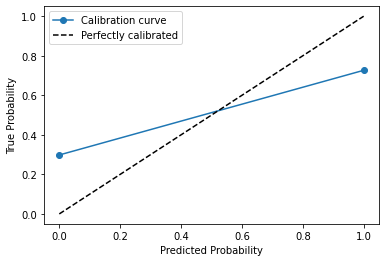

Residual Plot


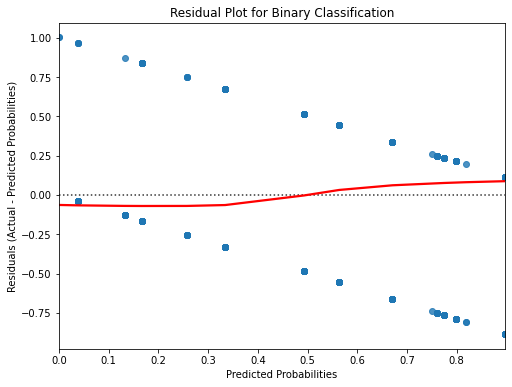

[[692 215]
 [294 571]]
RandomForestClassifier
[0 1]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       907
           1       0.67      0.68      0.67       865

    accuracy                           0.68      1772
   macro avg       0.68      0.68      0.68      1772
weighted avg       0.68      0.68      0.68      1772

Confusion Matrix
[[610 297]
 [275 590]]
Calibration Curve


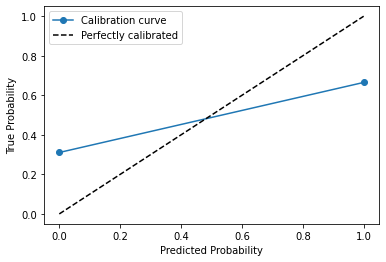

Residual Plot


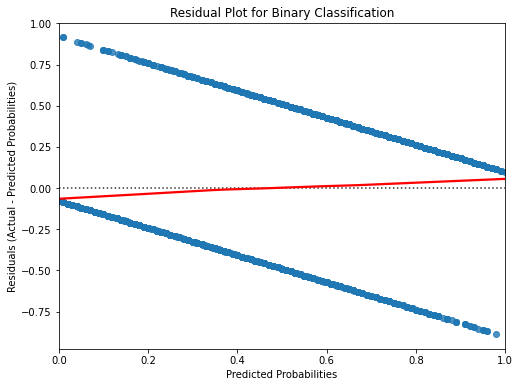

[[610 297]
 [275 590]]
svm.SVC
[0 1]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       907
           1       0.69      0.74      0.71       865

    accuracy                           0.71      1772
   macro avg       0.71      0.71      0.71      1772
weighted avg       0.71      0.71      0.71      1772

Confusion Matrix
[[623 284]
 [226 639]]
Calibration Curve


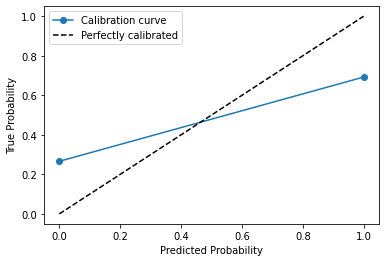

Residual Plot


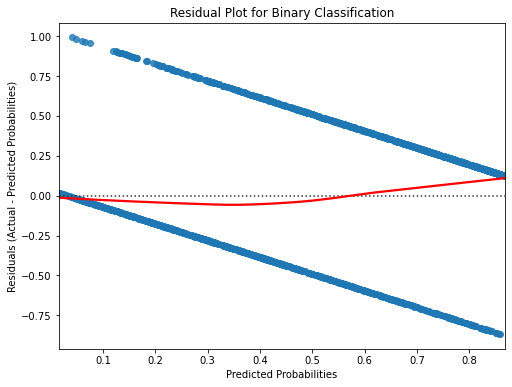

[[623 284]
 [226 639]]
KNeighborsClassifier
[0 1]
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       907
           1       0.69      0.53      0.60       865

    accuracy                           0.65      1772
   macro avg       0.66      0.65      0.65      1772
weighted avg       0.66      0.65      0.65      1772

Confusion Matrix
[[703 204]
 [408 457]]
Calibration Curve


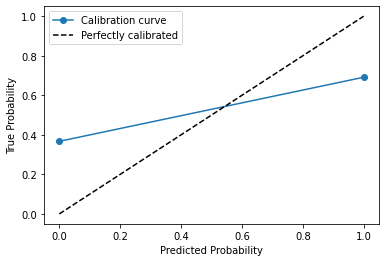

Residual Plot


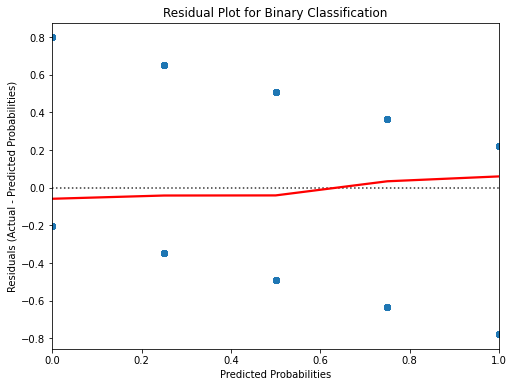

[[703 204]
 [408 457]]
svm_linear.SVC
[0 1]
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       907
           1       0.71      0.71      0.71       865

    accuracy                           0.72      1772
   macro avg       0.72      0.72      0.72      1772
weighted avg       0.72      0.72      0.72      1772

Confusion Matrix
[[658 249]
 [253 612]]
Calibration Curve


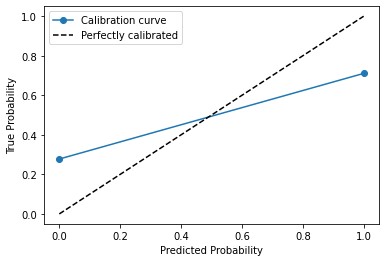

Residual Plot


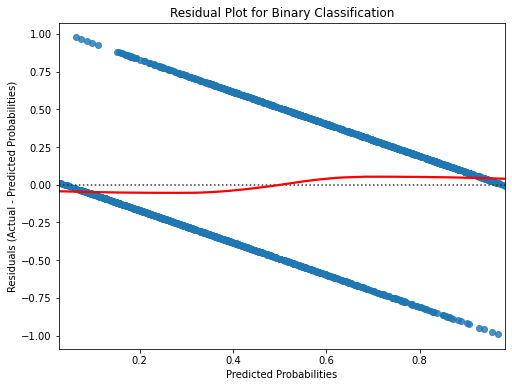

[[658 249]
 [253 612]]


In [60]:
offval,offmdl,mdl = classifier(X_off,y_off,42)

In [61]:
offval

,Model,CV Accuracy,CV MPCA,CV F1_weighted
0,DecisionTreeClassifier,0.709603,0.709610,0.709318
1,RandomForestClassifier,0.684066,0.684067,0.683966
2,svm.SVC,0.710543,0.710544,0.710186
3,KNeighborsClassifier,0.643387,0.643383,0.637841
4,svm_linear.SVC,0.711813,0.711814,0.711739


In [62]:
offmdl

,Model,Accuracy,MPCA,F1_weighted,Misclassification_Cost,unique predictions
0,DecisionTreeClassifier,0.712754,0.711535,0.711875,0.287246,"[0, 1]"
1,RandomForestClassifier,0.677201,0.677314,0.677246,0.322799,"[0, 1]"
2,svm.SVC,0.712190,0.712804,0.712105,0.287810,"[0, 1]"
3,KNeighborsClassifier,0.654628,0.651703,0.648999,0.345372,"[0, 1]"
4,svm_linear.SVC,0.716704,0.716492,0.716688,0.283296,"[0, 1]"


In [63]:
# train and save the best performing model (althought the combined model was the best, I will use the offensive stats model since it requires fewer inputs to make a prediction and this will make for a more user-friendly UI)
best_model = svm.SVC(kernel="linear",probability=True).fit(X_off, y_off) 

In [64]:
prediction = best_model.predict_proba(np.array(X_off.iloc[2,:]).reshape(-1,6))

In [65]:
best_model.classes_

array([0, 1], dtype=int64)

In [66]:
np.round(prediction[0][1]*100)

75.0

# Save Model

In [83]:
import joblib

joblib.dump(best_model,'offensive_stats_model.pkl')

['offensive_stats_model.pkl']

# Supplemental Code

In [141]:
'''
for df in scaled_df_lst:
    

    #define predictor and response variables
    X = df.drop(columns= ['outcome'],axis=1) #predictors
    y = df['outcome']              #response

    # convert class label column to int type
    y = y.astype(np.int_)

    from sklearn.model_selection import train_test_split as tts

    X_train, X_test, y_train, y_test = tts(X,y,random_state=3) 

    from collections import Counter

    train_count = Counter(y_train)
    test_count = Counter(y_test)

    print(train_count)
    print(test_count)


    #define model
    svc = SVC(kernel='rbf')

    model = svc.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy on test set: {accuracy}")

    from sklearn.metrics import classification_report

    #Precision, recall, f1-score and support
    print(classification_report(y_test, y_pred))
'''

Counter({0: 2692, 1: 2624})
Counter({1: 920, 0: 852})
Accuracy on test set: 0.6360045146726863
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       852
           1       0.63      0.73      0.67       920

    accuracy                           0.64      1772
   macro avg       0.64      0.63      0.63      1772
weighted avg       0.64      0.64      0.63      1772

Counter({0: 2692, 1: 2624})
Counter({1: 920, 0: 852})
Accuracy on test set: 0.6783295711060948
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       852
           1       0.68      0.73      0.70       920

    accuracy                           0.68      1772
   macro avg       0.68      0.68      0.68      1772
weighted avg       0.68      0.68      0.68      1772

Counter({0: 2692, 1: 2624})
Counter({1: 920, 0: 852})
Accuracy on test set: 0.79627539503386
              precision    recall  f1-score   support

        

In [33]:
'''
#Find what error value is in the 'DKP_per_minute' field
for i in range(0,df_full.shape[0]):
    try:
        float(df_full['DKP_per_minute'][i])      
    except ValueError as e:
        print(df_full['DKP_per_minute'][i])
        print(df_full.iloc[i])
        print(e)
        
'''

#NAME?
game_id                                     201912260SAC
game_date                            2019-12-26 00:00:00
OT                                                     2
H_A                                                    H
Team_Abbrev                                          SAC
Team_Score                                           104
Team_pace                                           92.7
Team_efg_pct                                       0.388
Team_tov_pct                                         9.2
Team_orb_pct                                        23.9
Team_ft_rate                                       0.196
Team_off_rtg                                        92.8
Opponent_Abbrev                                      MIN
Opponent_Score                                       105
Opponent_pace                                       92.7
Opponent_efg_pct                                   0.394
Opponent_tov_pct                                    10.0
Opponent_orb_pct        